In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [4]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [5]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    concat_df = concat_df.reset_index(drop=True)
    
    return concat_df

In [34]:
apart_df = data_prep('아파트', '매매')
print(apart_df.shape)
apart_df.head()

16it [00:03,  5.11it/s]


(1191637, 11)


,지번주소,도로명,단지명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,59500,7,1988,18,2006-03-10,765.273312,33
1,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,60000,6,1988,18,2006-03-29,771.704180,33
2,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,67000,9,1988,18,2006-04-29,861.736334,33
3,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,60000,4,1988,18,2006-06-01,771.704180,33
4,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,72250,5,1988,18,2006-10-20,929.260450,33


In [6]:
yunrip_df = data_prep('연립다세대', '매매')
print(yunrip_df.shape)
yunrip_df.head()

16it [00:02,  6.95it/s]


(688568, 12)


,지번주소,도로명,건물명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 1264-3,개포로31길 23-7,(1264-3),53.28,29.23,11500,-1,1992.0,14.0,2006-08-29,215.840841,29.0
1,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0
3,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0
4,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0


In [7]:
officetel_df = data_prep('오피스텔', '매매')
print(officetel_df.shape)
officetel_df.head()

16it [00:00, 23.46it/s]


(178440, 11)


,지번주소,도로명,단지명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,6400,8,1997.0,9.0,2006-01-10,197.287300,24.0
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7100,7,1997.0,9.0,2006-01-10,218.865598,24.0
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7300,11,1997.0,9.0,2006-01-11,225.030826,24.0
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,7500,10,1997.0,9.0,2006-01-18,235.036039,24.0
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7400,15,1997.0,9.0,2006-01-19,228.113440,24.0


In [35]:
apart_df['구'] = apart_df['지번주소'].apply(lambda x: x.split(' ')[1])
apart_df['동'] = apart_df['지번주소'].apply(lambda x: x.split(' ')[2])
yunrip_df['구'] = yunrip_df['지번주소'].apply(lambda x: x.split(' ')[1])
yunrip_df['동'] = yunrip_df['지번주소'].apply(lambda x: x.split(' ')[2])
officetel_df['구'] = officetel_df['지번주소'].apply(lambda x: x.split(' ')[1])
officetel_df['동'] = officetel_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [118]:
target_gu = '성동구'
target_dong = '수유동'

In [119]:
apart_target_df = apart_df[
    (apart_df['구'] == target_gu)
    &(apart_df['동'] == target_dong)
    &(apart_df['계약날짜'] >= (date_today - pd.DateOffset(months=18)))
    &(apart_df['건물연식'] <= 4)
    #&(yunrip_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(apart_target_df.shape)
apart_target_df.head()

(0, 13)


,지번주소,도로명,단지명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,구,동


In [120]:
yunrip_target_df = yunrip_df[
    (yunrip_df['구'] == target_gu)
    #&(yunrip_df['동'] == target_dong)
    &(yunrip_df['계약날짜'] >= (date_today - pd.DateOffset(months=18)))
    &(yunrip_df['건물연식'] <= 4)
    #&(yunrip_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(yunrip_target_df.shape)
yunrip_target_df.head()

(111, 14)


,지번주소,도로명,건물명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,구,동
595925,서울특별시 성동구 금호동3가 562-0,무수막3길 21,샤인빌,29.82,25.38,54000,2,2019.0,0.0,2019-11-11,1810.865191,2.0,성동구,금호동3가
595936,서울특별시 성동구 금호동3가 175-1,금호산2길 43,청목빌,29.93,21.49,52900,3,2019.0,0.0,2019-12-14,1767.457401,2.0,성동구,금호동3가
596032,서울특별시 성동구 성수동1가 656-1040,왕십리로10길 5-27,뚝섬리치빌B동,14.13,9.19,16000,5,2017.0,2.0,2019-12-10,1132.342534,4.0,성동구,성수동1가
596067,서울특별시 성동구 성수동2가 289-154,광나루로 244-15,(289-154),29.81,19.20,29700,6,2017.0,2.0,2019-12-03,996.309963,4.0,성동구,성수동2가
596138,서울특별시 성동구 성수동2가 289-82,아차산로7길 17-18,프라임51,27.74,15.07,25500,5,2017.0,2.0,2019-11-02,919.250180,4.0,성동구,성수동2가


In [121]:
officetel_target_df = officetel_df[
    (officetel_df['구'] == target_gu)
    #&(officetel_df['동'] == target_dong)
    &(officetel_df['계약날짜'] >= (date_today - pd.DateOffset(months=18)))
    &(officetel_df['건물연식'] <= 4)
    #&(officetel_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(officetel_target_df.shape)
officetel_target_df.head()

(54, 13)


,지번주소,도로명,단지명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,구,동
154771,서울특별시 성동구 성수동1가 13-163,상원6나길 24,청호 서울숲 뜨레피움 오피스텔,19.03,22085,2,2018.0,1.0,2019-11-21,1160.535996,3.0,성동구,성수동1가
154918,서울특별시 성동구 홍익동 146-1,왕십리로20길 40,비앤리베스텔,15.98,10000,7,2018.0,1.0,2019-11-20,625.782228,3.0,성동구,홍익동
167446,서울특별시 성동구 도선동 46-0,왕십리로 320,W에비뉴타워,23.32,24250,6,2018.0,2.0,2020-07-11,1039.879931,3.0,성동구,도선동
167447,서울특별시 성동구 도선동 46-0,왕십리로 320,W에비뉴타워,48.30,50000,15,2018.0,2.0,2020-07-15,1035.196687,3.0,성동구,도선동
167450,서울특별시 성동구 도선동 268-0,무학로2길 30,렉스오피스텔,21.27,21500,7,2018.0,2.0,2020-05-26,1010.813352,3.0,성동구,도선동


<AxesSubplot:ylabel='단가(만원/㎡)'>

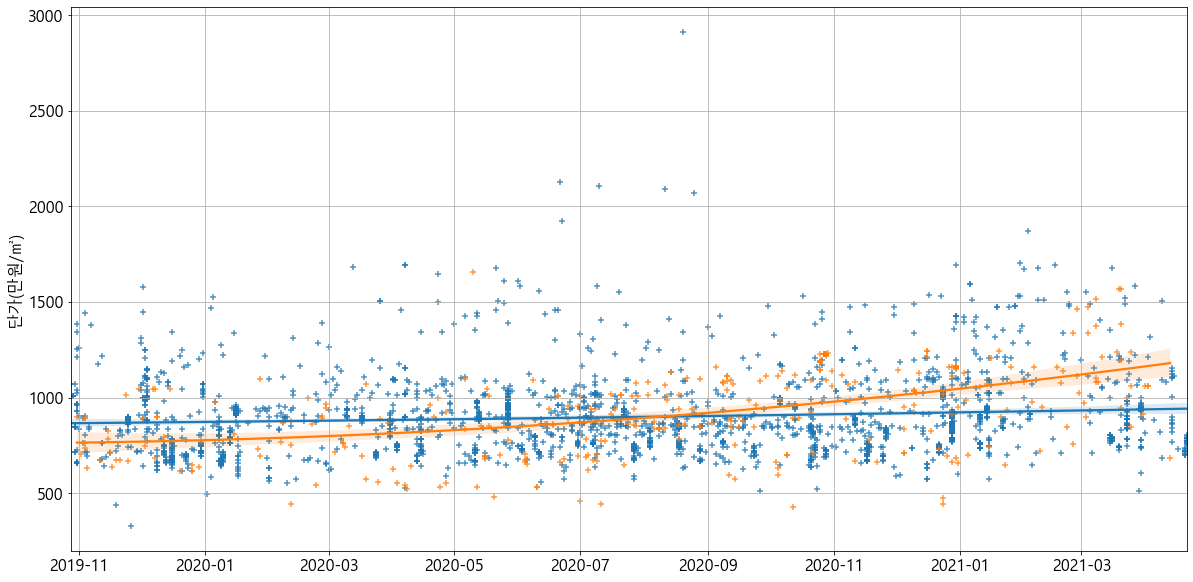

In [127]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
#plt.title('위 오피스텔(파랑)과 연립다세대(주홍) 비교'.format(target_gu, target_dong, target_df.shape[0]))
plt.grid(True)
#ax.xaxis.update_units(apart_target_df['계약날짜'])
#sns.regplot(x=ax.xaxis.convert_units(apart_target_df['계약날짜']), y=apart_target_df['단가(만원/㎡)'], scatter=False, order=4)
ax.xaxis.update_units(yunrip_target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(yunrip_target_df['계약날짜']), y=yunrip_target_df['단가(만원/㎡)'], order=2, marker='+')
ax.xaxis.update_units(officetel_target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(officetel_target_df['계약날짜']), y=officetel_target_df['단가(만원/㎡)'], order=2, marker='+')
#plt.ylim(0, 2000)
#plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대/오피스텔_연립다세대_비교_산포도.png'.format(target_gu, target_dong))

In [123]:
gu_list = ['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구', '도봉구', '노원구',
           '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구', '영등포구', '동작구', '관악구', '서초구',
           '강남구', '송파구', '강동구'
          ]

종로구


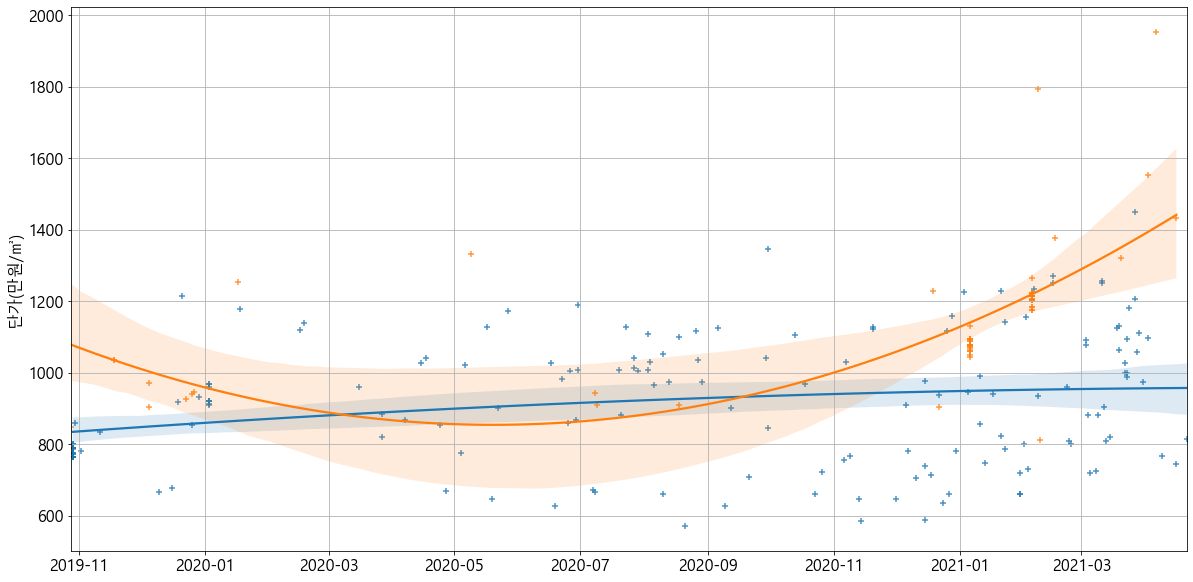

중구


<Figure size 432x288 with 0 Axes>

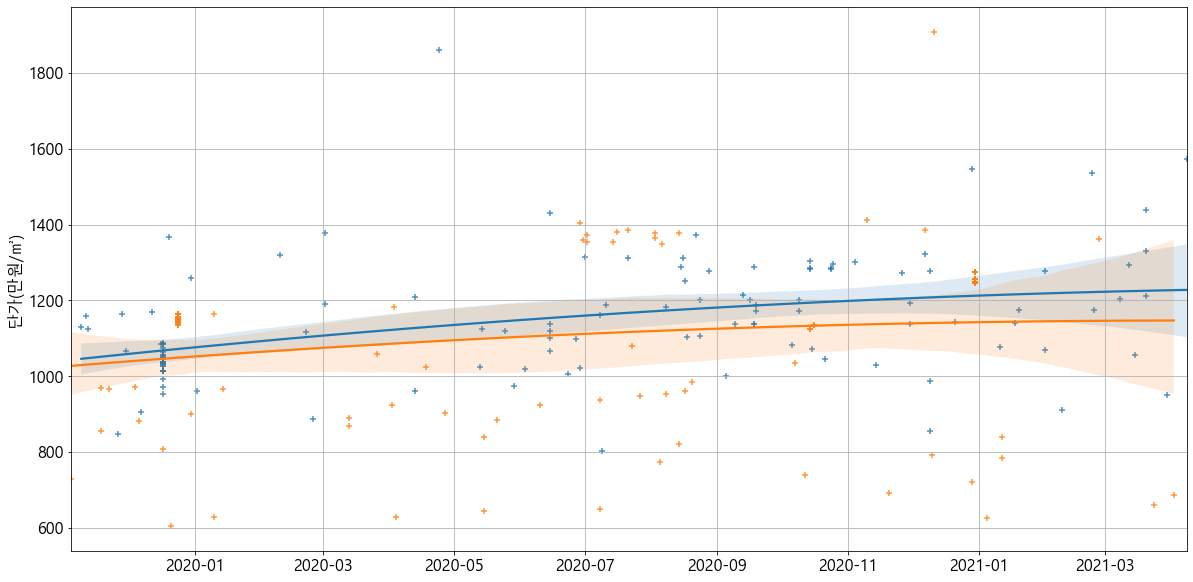

용산구


<Figure size 432x288 with 0 Axes>

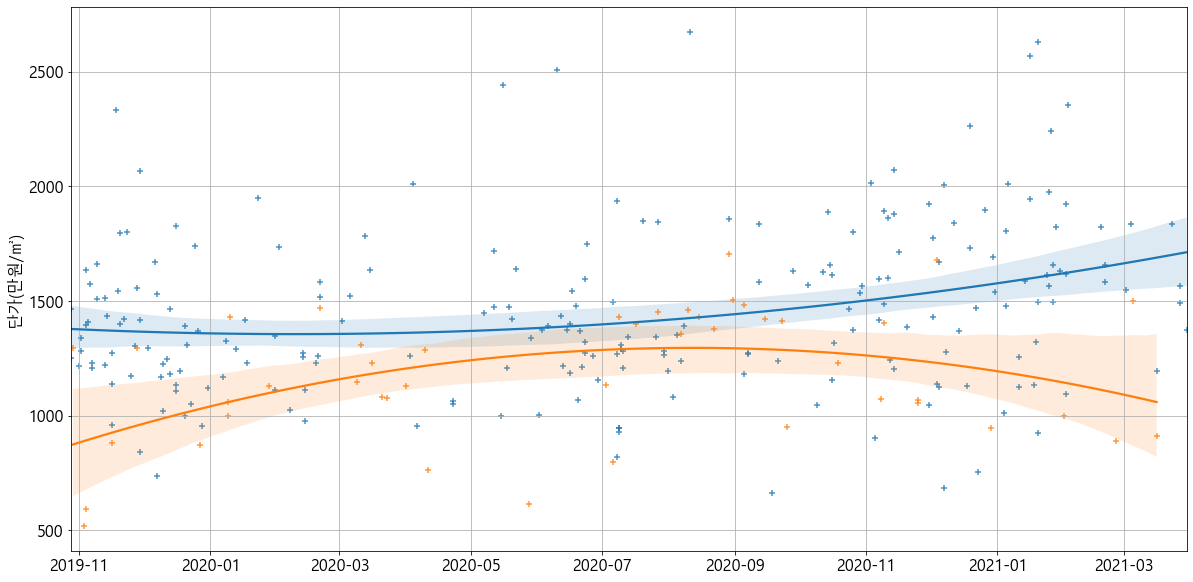

성동구


<Figure size 432x288 with 0 Axes>

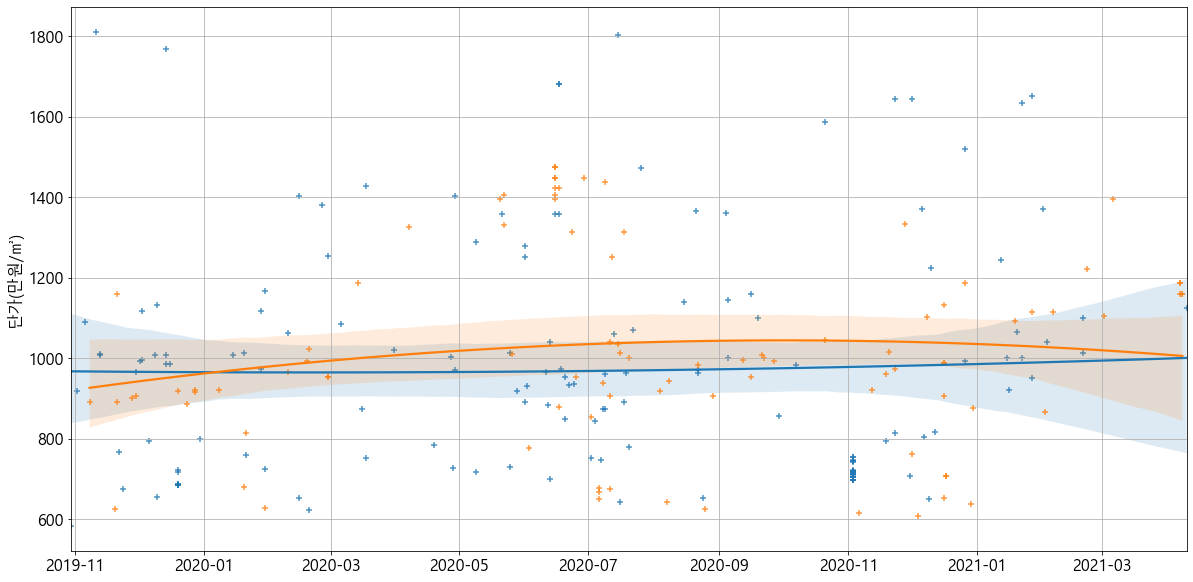

광진구


<Figure size 432x288 with 0 Axes>

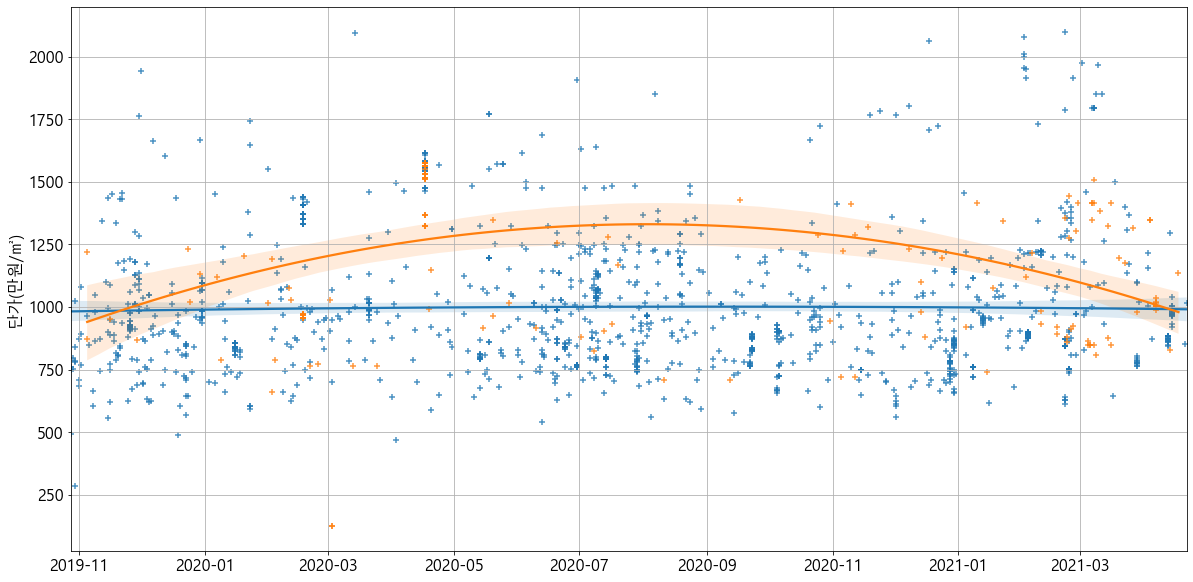

동대문구


<Figure size 432x288 with 0 Axes>

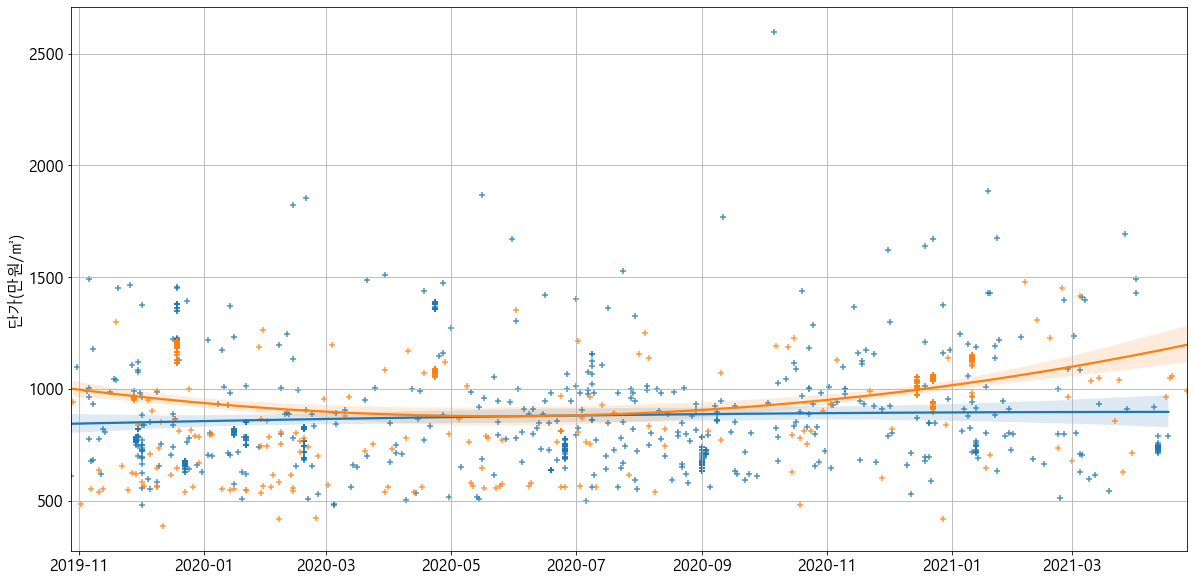

중랑구


<Figure size 432x288 with 0 Axes>

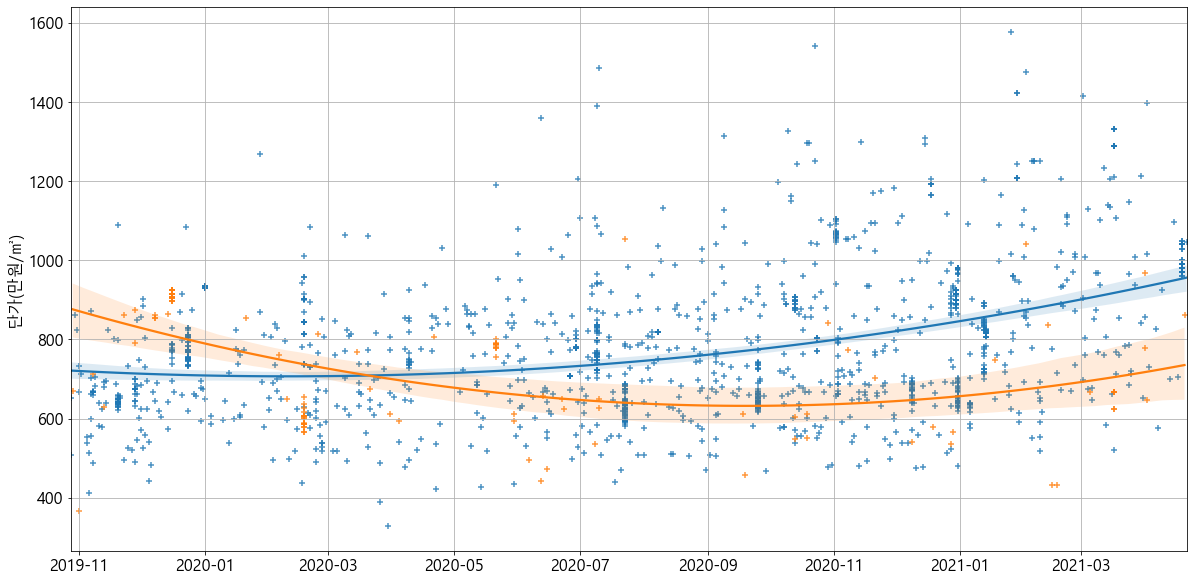

성북구


<Figure size 432x288 with 0 Axes>

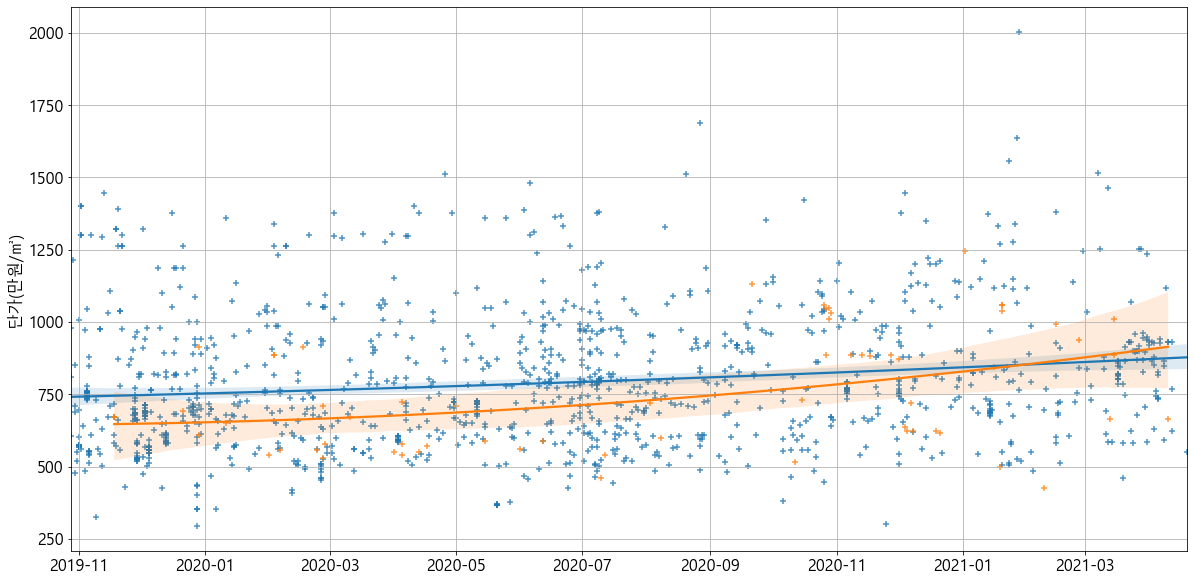

강북구


<Figure size 432x288 with 0 Axes>

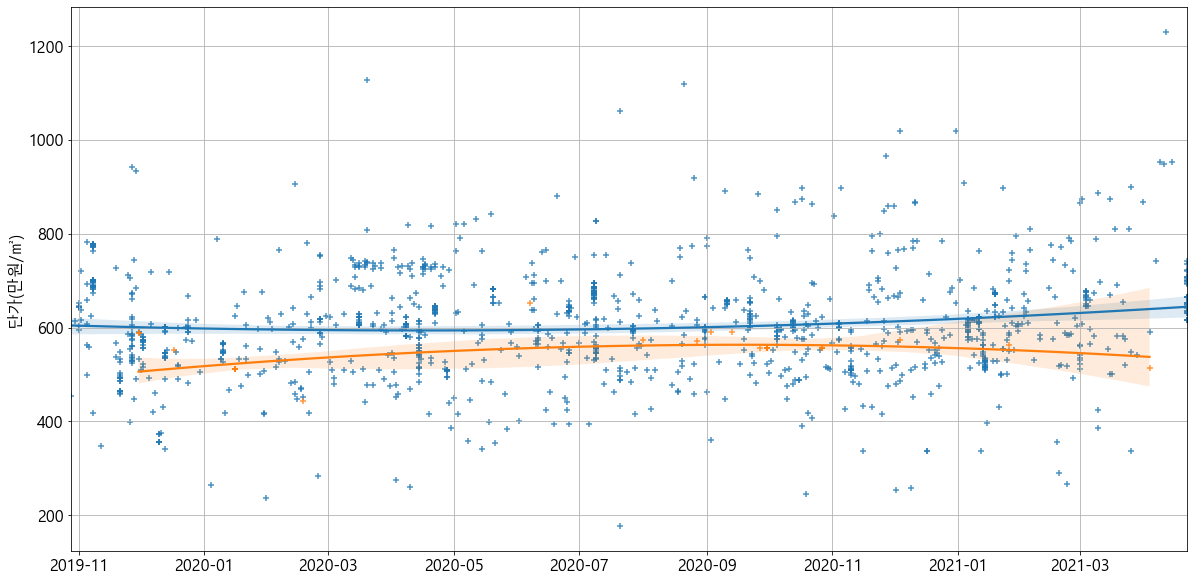

도봉구


<Figure size 432x288 with 0 Axes>

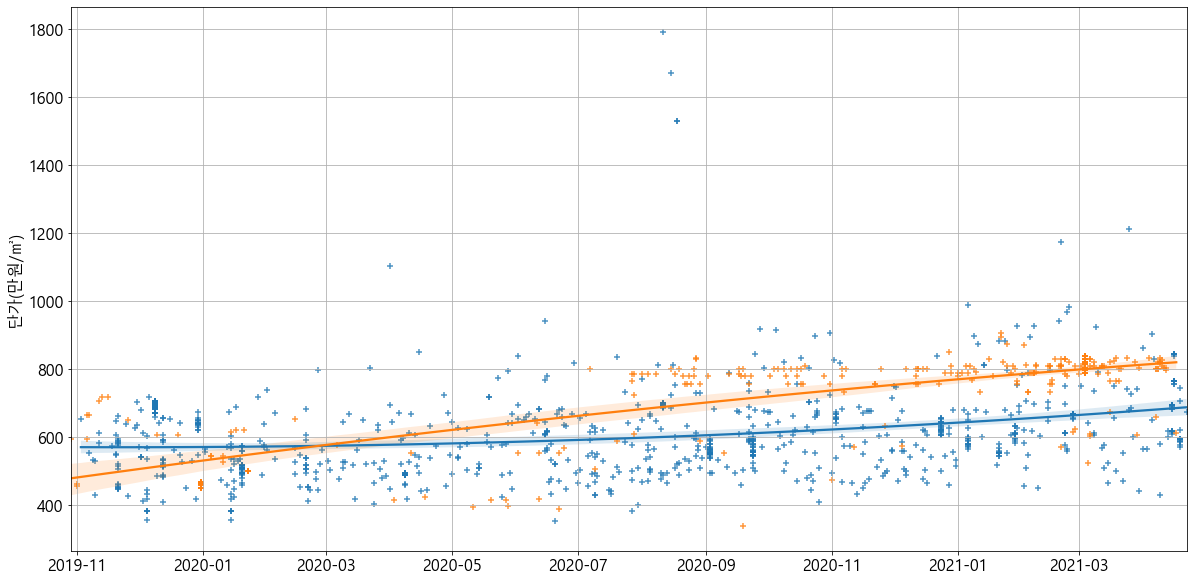

노원구


c:\users\max6296\ml\lib\site-packages\seaborn\regression.py:256: RankWarning: Polyfit may be poorly conditioned
  yhat = reg_func(x, y)
c:\users\max6296\ml\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
c:\users\max6296\ml\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
c:\users\max6296\ml\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
c:\users\max6296\ml\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
c:\users\max6296\ml\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
c:\users\max6296\ml\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Po

<Figure size 432x288 with 0 Axes>

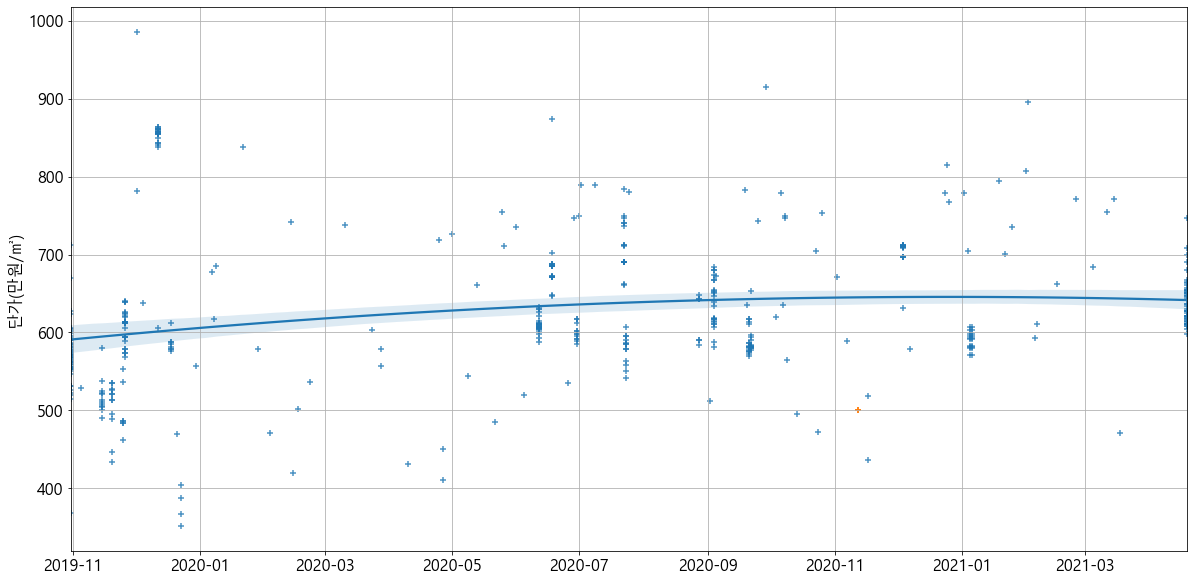

은평구


<Figure size 432x288 with 0 Axes>

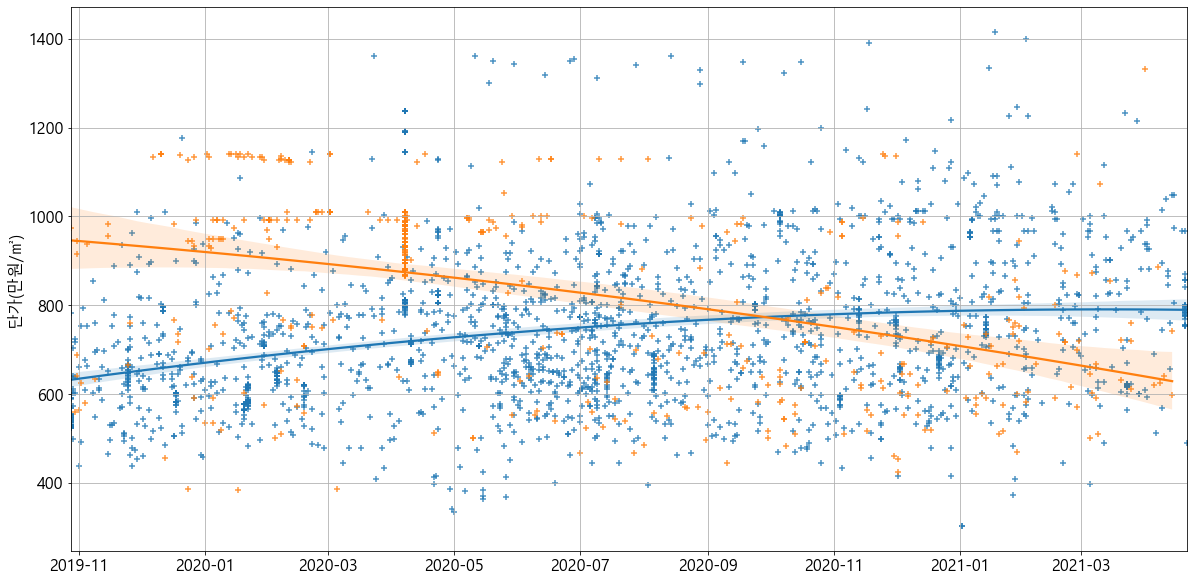

서대문구


<Figure size 432x288 with 0 Axes>

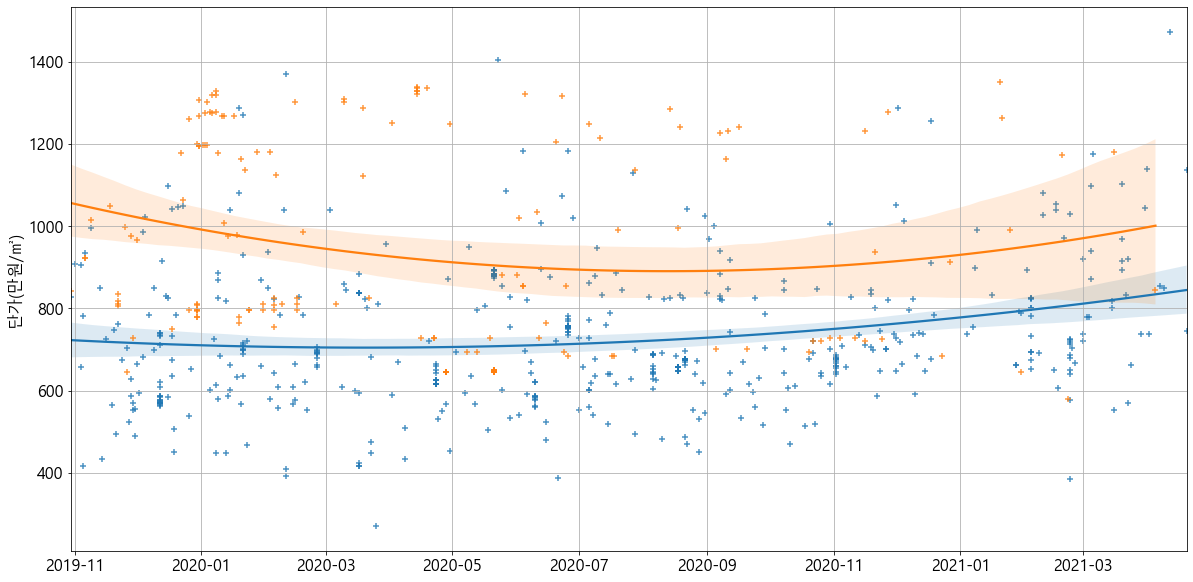

마포구


<Figure size 432x288 with 0 Axes>

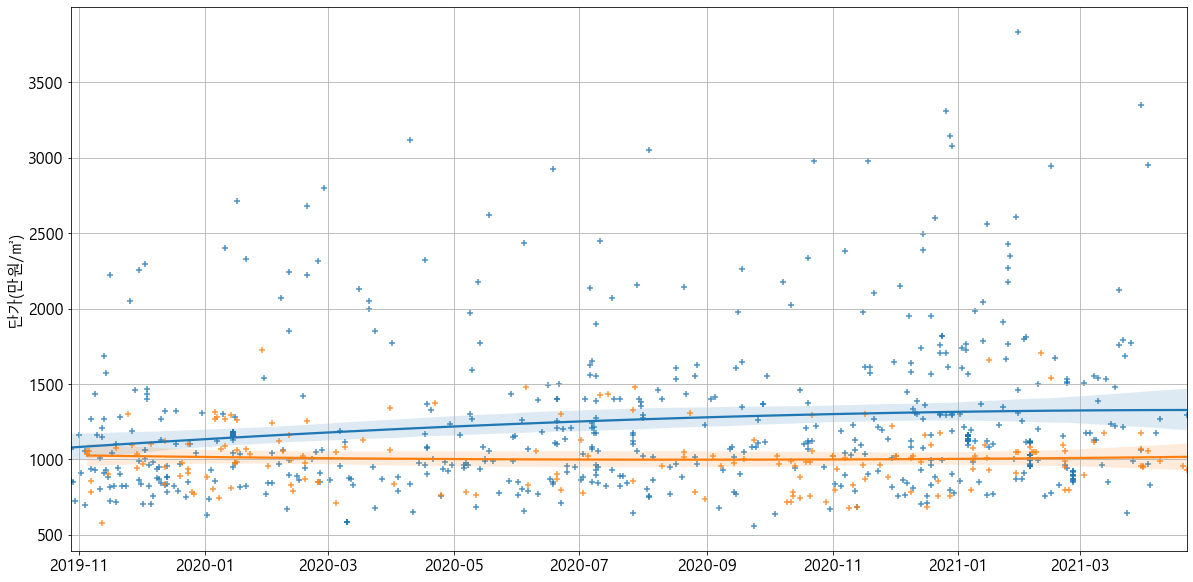

양천구


<Figure size 432x288 with 0 Axes>

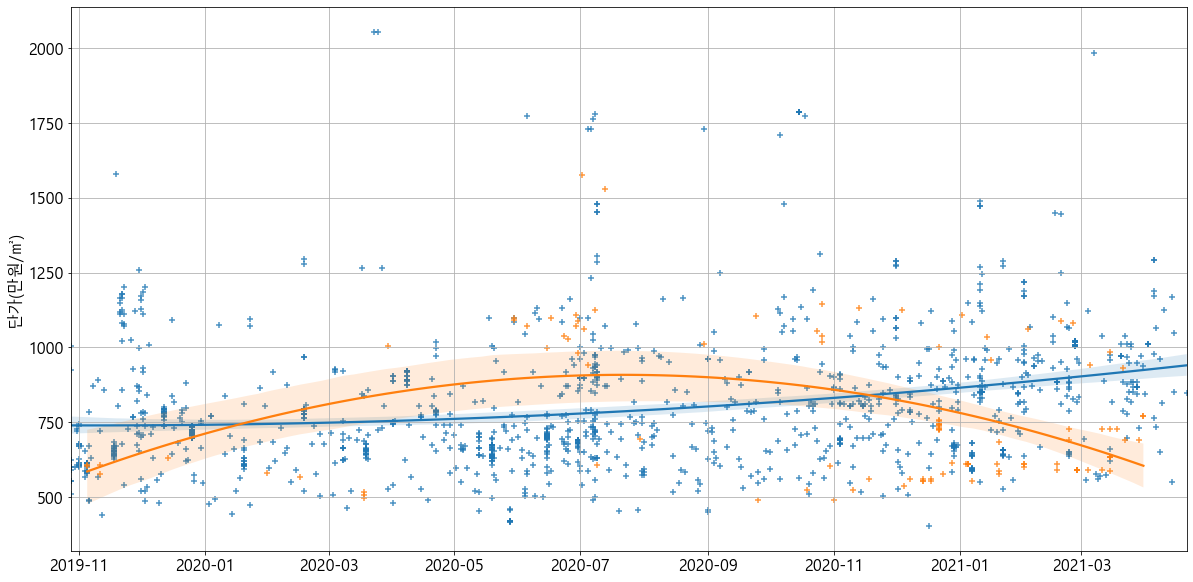

강서구


<Figure size 432x288 with 0 Axes>

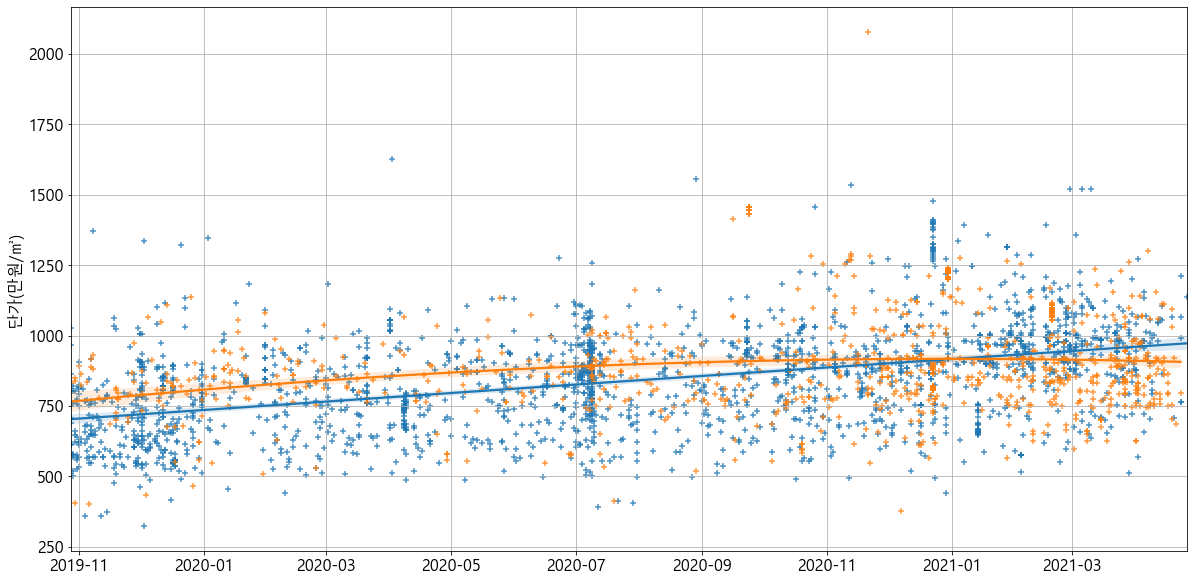

구로구


<Figure size 432x288 with 0 Axes>

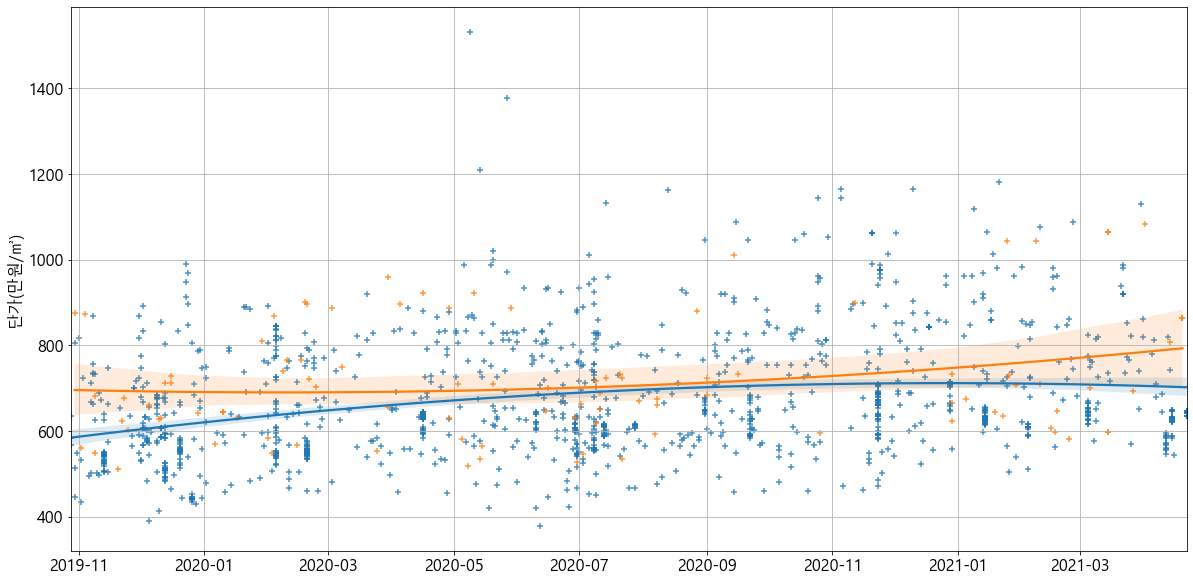

금천구


<Figure size 432x288 with 0 Axes>

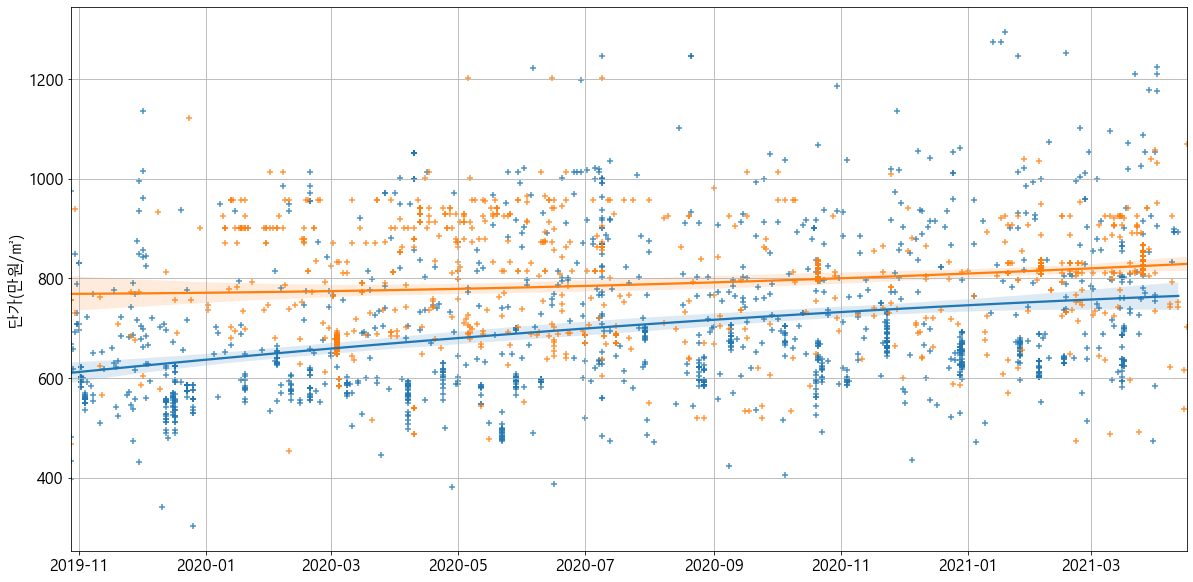

영등포구


<Figure size 432x288 with 0 Axes>

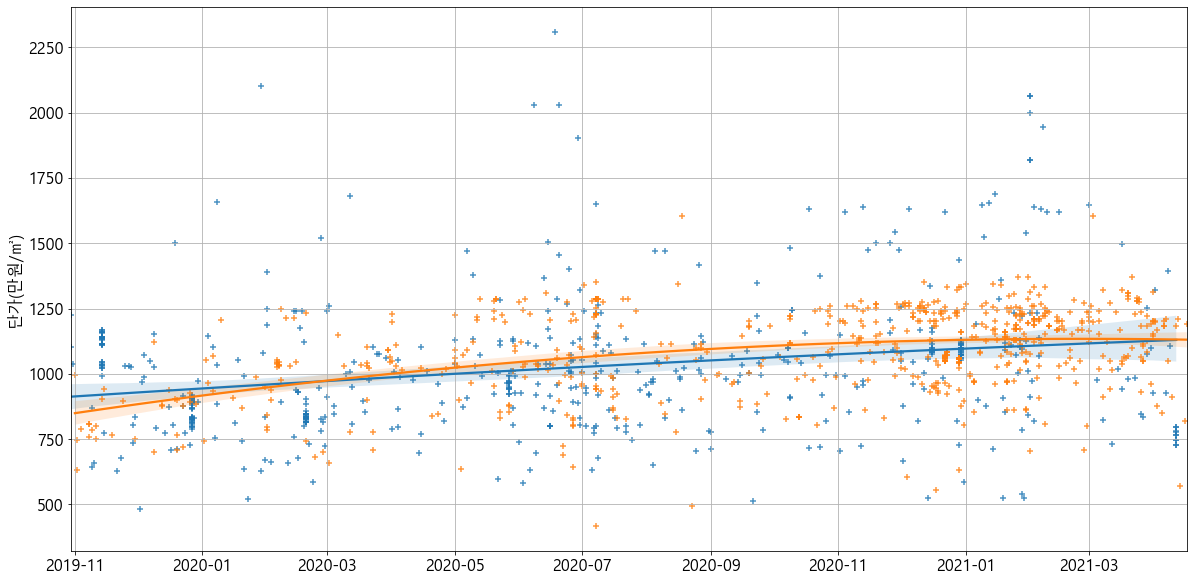

동작구


<Figure size 432x288 with 0 Axes>

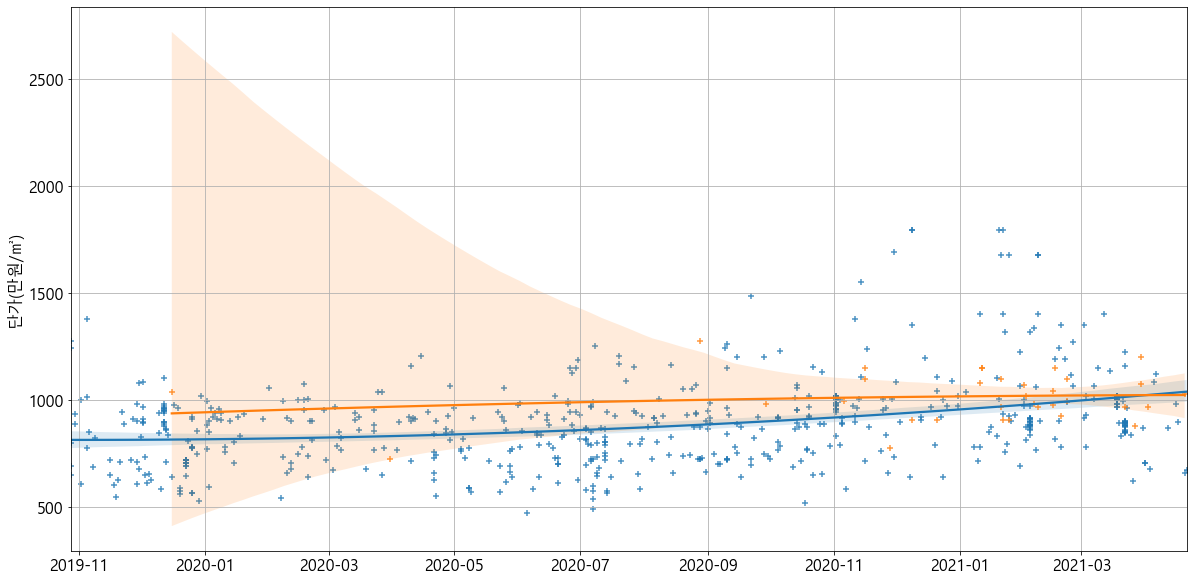

관악구


<Figure size 432x288 with 0 Axes>

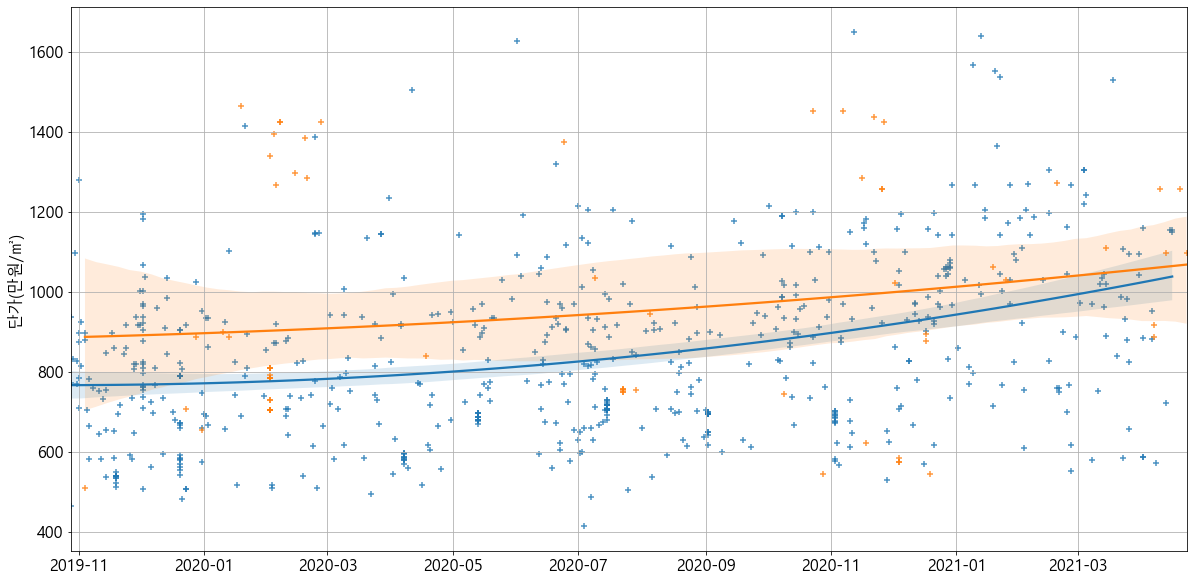

서초구


<Figure size 432x288 with 0 Axes>

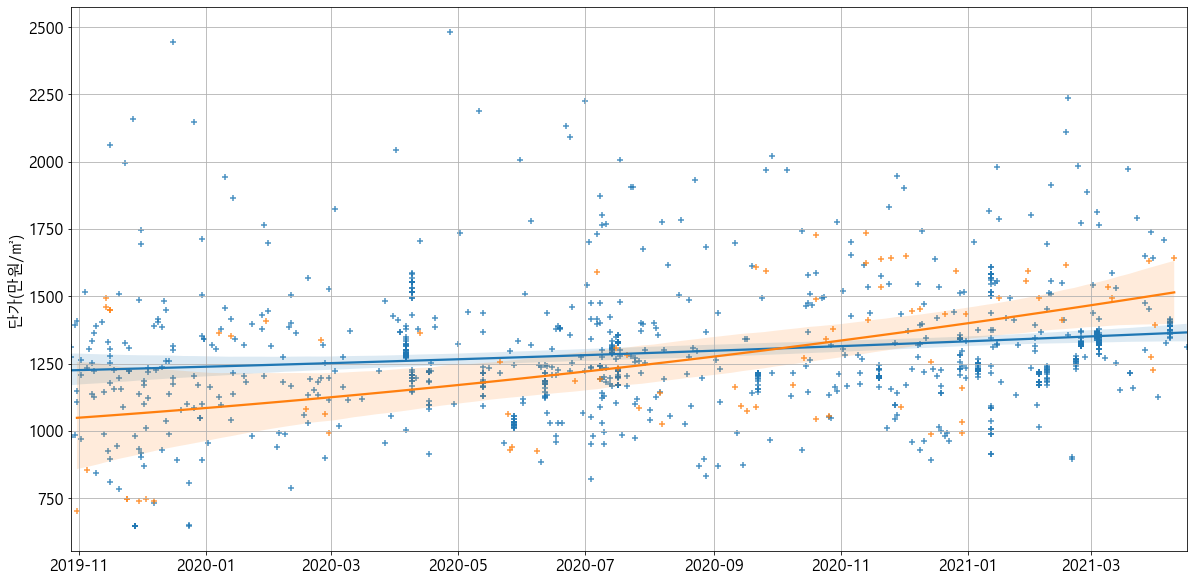

강남구


<Figure size 432x288 with 0 Axes>

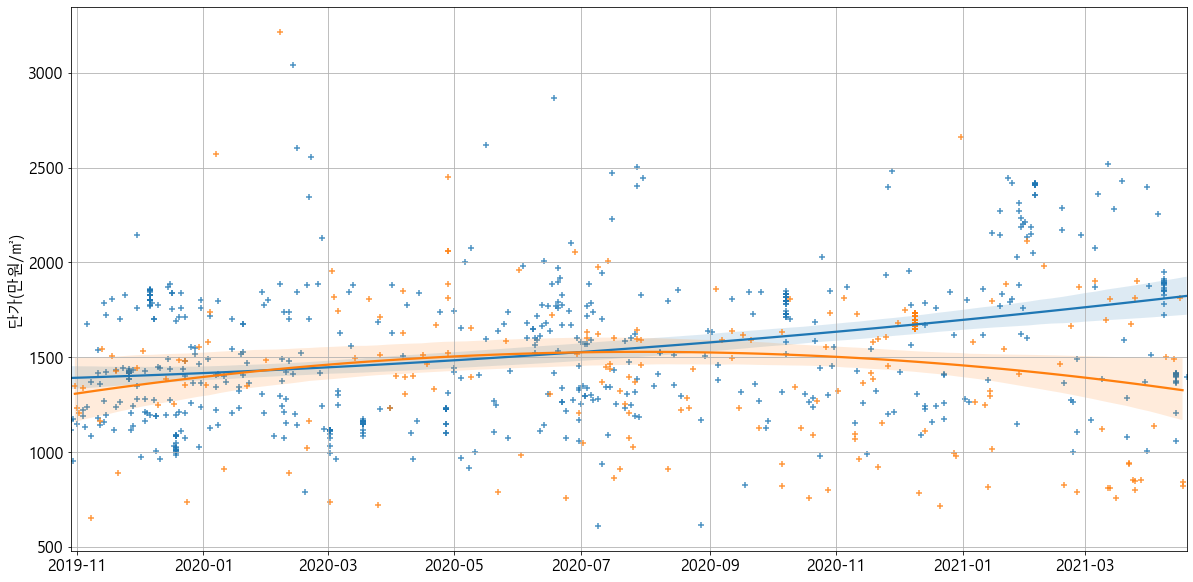

송파구


<Figure size 432x288 with 0 Axes>

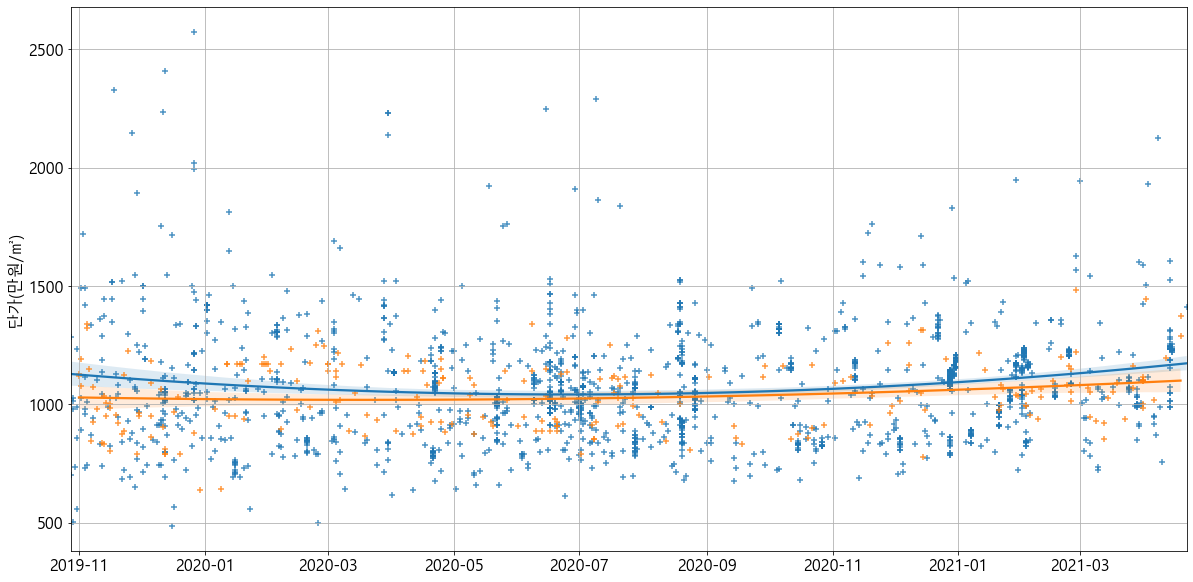

강동구


<Figure size 432x288 with 0 Axes>

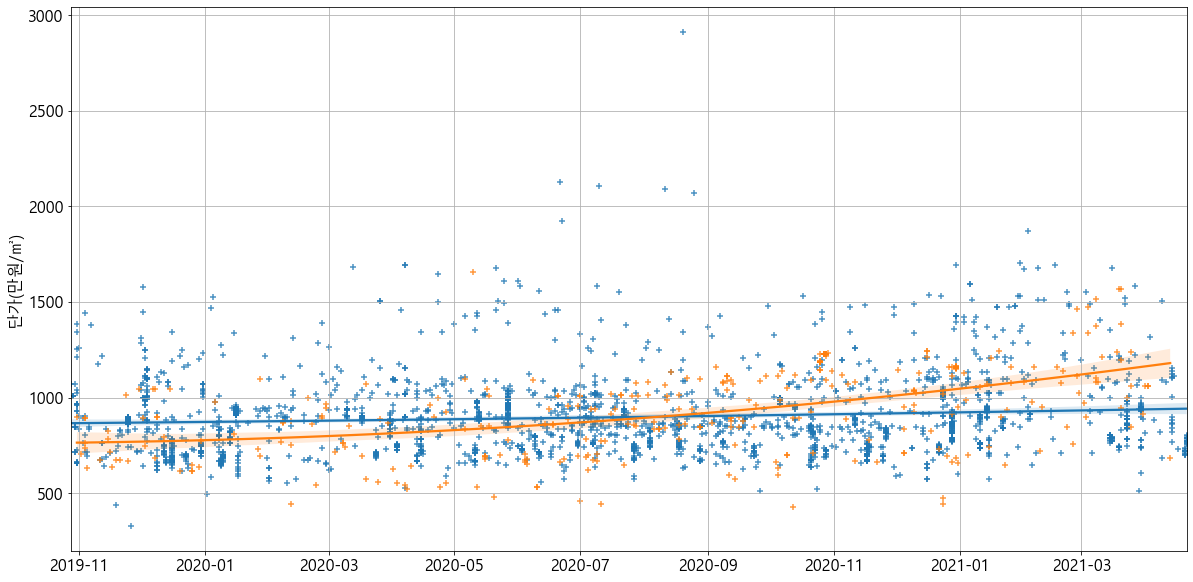

<Figure size 432x288 with 0 Axes>

In [125]:
for gu in gu_list:
    
    print(gu)
    yunrip_target_df = yunrip_df[
    (yunrip_df['구'] == gu)
    &(yunrip_df['계약날짜'] >= (date_today - pd.DateOffset(months=18)))
    &(yunrip_df['계약날짜기준_건물연식'] <= 4)
    ]
    
    officetel_target_df = officetel_df[
    (officetel_df['구'] == gu)
    &(officetel_df['계약날짜'] >= (date_today - pd.DateOffset(months=18)))
    &(officetel_df['계약날짜기준_건물연식'] <= 4)
    ]
    
    
    font = {'size': 16}
    matplotlib.rc('font', **font)
    f, ax = plt.subplots(figsize=(20,10))
    plt.grid(True)
    ax.xaxis.update_units(yunrip_target_df['계약날짜'])
    sns.regplot(x=ax.xaxis.convert_units(yunrip_target_df['계약날짜']), y=yunrip_target_df['단가(만원/㎡)'], order=2, marker='+')
    ax.xaxis.update_units(officetel_target_df['계약날짜'])
    sns.regplot(x=ax.xaxis.convert_units(officetel_target_df['계약날짜']), y=officetel_target_df['단가(만원/㎡)'], order=2, marker='+')
    
    plt.show()
    plt.clf()